In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


In [23]:
data = pd.read_csv(r"S:\Data\framingham_heart_disease.csv")
data

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0


In [24]:
#Lowercase the column headers and take a look at how many null values we are working with
data.columns = map(str.lower, data.columns)
target_variable = 'tenyearchd'
data.isna().sum()

male                 0
age                  0
education          105
currentsmoker        0
cigsperday          29
bpmeds              53
prevalentstroke      0
prevalenthyp         0
diabetes             0
totchol             50
sysbp                0
diabp                0
bmi                 19
heartrate            1
glucose            388
tenyearchd           0
dtype: int64

In [25]:
#Lets drop the education column (irrelevance) and values with low NaN counts. We'll attempt to impute values for totChol,glucose, and BPMeds in the coming steps.
data = data.drop('education', axis=1)
data = data.dropna(subset=['cigsperday','bmi','heartrate'])
data.isna().sum()

male                 0
age                  0
currentsmoker        0
cigsperday           0
bpmeds              53
prevalentstroke      0
prevalenthyp         0
diabetes             0
totchol             49
sysbp                0
diabp                0
bmi                  0
heartrate            0
glucose            379
tenyearchd           0
dtype: int64

In [26]:
#Here we'll use KNN to impute missing values into the dataset, opting out of sklearn's SimpleImputer
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target] #Get values of our target column that aren't missing.
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns] #All columns that aren't null as well as our target column
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns] #Null values in the target with non-null columnes
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

In [27]:
data = knn_impute(data,'glucose')
data.isna().sum()

male                0
age                 0
currentsmoker       0
cigsperday          0
bpmeds             53
prevalentstroke     0
prevalenthyp        0
diabetes            0
totchol            49
sysbp               0
diabp               0
bmi                 0
heartrate           0
glucose             0
tenyearchd          0
dtype: int64

In [28]:
data = knn_impute(data,'bpmeds')
data.isna().sum()

male                0
age                 0
currentsmoker       0
cigsperday          0
bpmeds              0
prevalentstroke     0
prevalenthyp        0
diabetes            0
totchol            49
sysbp               0
diabp               0
bmi                 0
heartrate           0
glucose             0
tenyearchd          0
dtype: int64

In [29]:
data = knn_impute(data,'totchol')
data.isna().sum()

male               0
age                0
currentsmoker      0
cigsperday         0
bpmeds             0
prevalentstroke    0
prevalenthyp       0
diabetes           0
totchol            0
sysbp              0
diabp              0
bmi                0
heartrate          0
glucose            0
tenyearchd         0
dtype: int64

In [30]:
data.head()

,male,age,currentsmoker,cigsperday,bpmeds,prevalentstroke,prevalenthyp,diabetes,totchol,sysbp,diabp,bmi,heartrate,glucose,tenyearchd
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


[Text(0, 0, 'male'),
 Text(1, 0, 'age'),
 Text(2, 0, 'currentsmoker'),
 Text(3, 0, 'cigsperday'),
 Text(4, 0, 'bpmeds'),
 Text(5, 0, 'prevalentstroke'),
 Text(6, 0, 'prevalenthyp'),
 Text(7, 0, 'diabetes'),
 Text(8, 0, 'totchol'),
 Text(9, 0, 'sysbp'),
 Text(10, 0, 'diabp'),
 Text(11, 0, 'bmi'),
 Text(12, 0, 'heartrate'),
 Text(13, 0, 'glucose'),
 Text(14, 0, 'tenyearchd')]

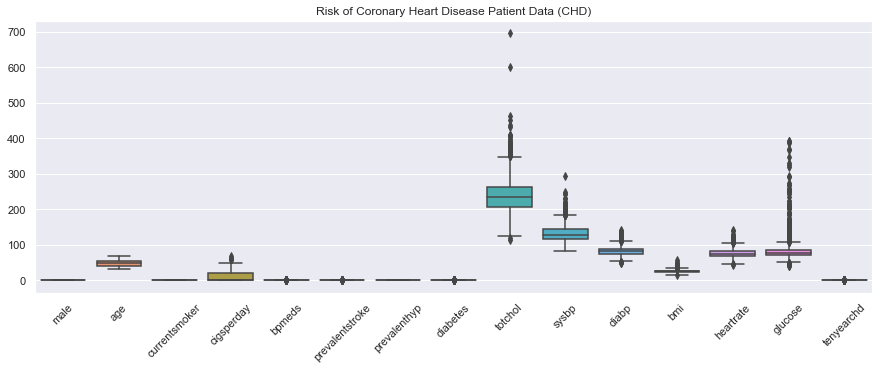

In [31]:
#Box and Whisker Plot to get a quick visual of our data and distribution.
sns.set(rc={'figure.figsize':(15,5)})
ax=sns.boxplot(data=data)
ax.set(title='Risk of Coronary Heart Disease Patient Data (CHD)')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

#We can see a lot of outliers for cholesteral, systolic blood pressure, and glucose. 
#We'll have to do a correlation matrix in the next few steps to see if those correlate with CHD

In [32]:
#Summary stats view. Sheesh, someone in this dataset smokes 70 cigarettes per day????
data.describe()

,male,age,currentsmoker,cigsperday,bpmeds,prevalentstroke,prevalenthyp,diabetes,totchol,sysbp,diabp,bmi,heartrate,glucose,tenyearchd
count,4189.000000,4189.000000,4189.000000,4189.000000,4189.000000,4189.000000,4189.000000,4189.000000,4189.000000,4189.000000,4189.000000,4189.000000,4189.000000,4189.000000,4189.000000
mean,0.429458,49.573884,0.491048,9.015756,0.029745,0.005491,0.310575,0.025543,236.716973,132.323705,82.899499,25.800852,75.864407,81.921318,0.150633
std,0.495058,8.567396,0.499980,11.929582,0.169113,0.073904,0.462784,0.157787,44.360051,21.971407,11.895414,4.082750,12.023804,22.902042,0.357733
min,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,72.000000,0.000000
50%,0.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.500000,28.040000,83.000000,86.600000,0.000000
max,1.000000,70.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


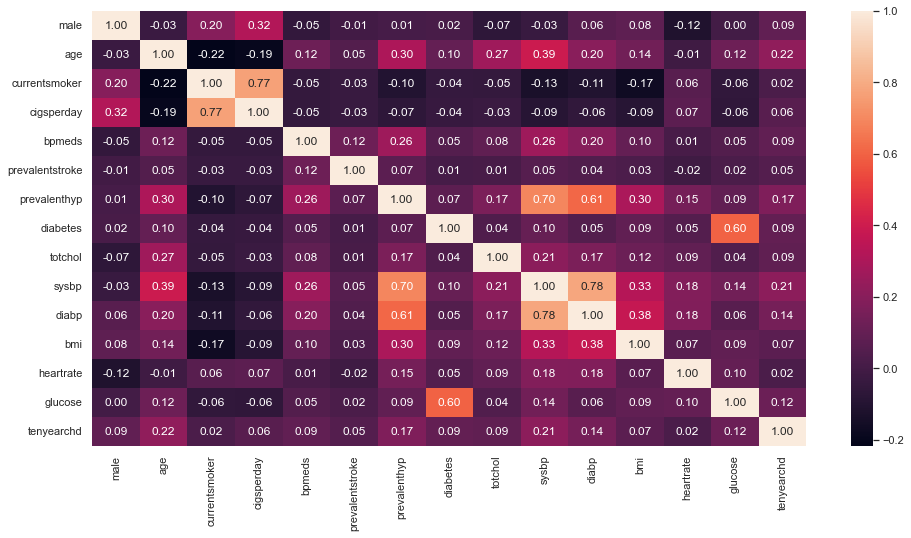

In [33]:
#Correlation Matrix
plt.figure(figsize= (16, 8))
sns.heatmap(data.corr(), annot = True, fmt= '.2f');


#Glucose and Diabetes, as well as hypertension prevelancy and BP measurements obviously have a significant R-square, 
#but it's surprising to see how many moderate correlations arise with age. 
#The majority (64%, +-1 stddev) of the patients in this dataset are between 41 and 58 years old.

<AxesSubplot:xlabel='tenyearchd', ylabel='count'>

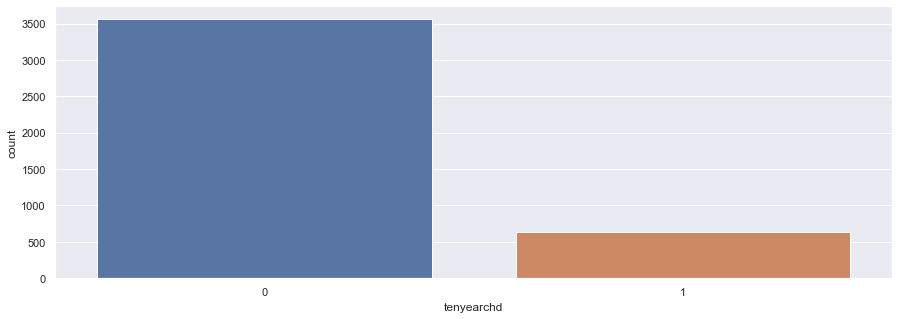

In [34]:
#Checking prevalence of our target variable, tenyearCHD. We may need to SMOTE to balance out the sampling of this dataset.
sns.countplot(x=data[target_variable])

In [35]:
#Data Normalization with StandardScaler
sc = StandardScaler()
data[["age","cigsperday","totchol","sysbp","diabp","bmi","heartrate","glucose"]] = sc.fit_transform(data[["age",
"cigsperday","totchol","sysbp","diabp","bmi","heartrate","glucose"]])
data.head()

,male,age,currentsmoker,cigsperday,bpmeds,prevalentstroke,prevalenthyp,diabetes,totchol,sysbp,diabp,bmi,heartrate,glucose,tenyearchd
0,1,-1.234348,0,-0.755838,0.0,0,0,0,-0.940530,-1.198232,-1.084539,0.286397,0.343992,-0.214911,0
1,0,-0.417199,0,-0.755838,0.0,0,0,0,0.299472,-0.515445,-0.159702,0.717530,1.591666,-0.258581,0
2,1,-0.183728,1,0.920867,0.0,0,0,0,0.186745,-0.219571,-0.243778,-0.112891,-0.071900,-0.520597,0
3,0,1.333833,1,1.759219,0.0,0,1,0,-0.264165,0.804610,1.017362,0.680786,-0.903683,0.920494,1
4,0,-0.417199,1,1.172372,0.0,0,0,0,1.088565,-0.105773,0.092526,-0.661607,0.759883,0.134444,0


In [36]:
#Split our X and y sets
data.copy()
X=data.drop([target_variable], axis=1)
y=data[target_variable]

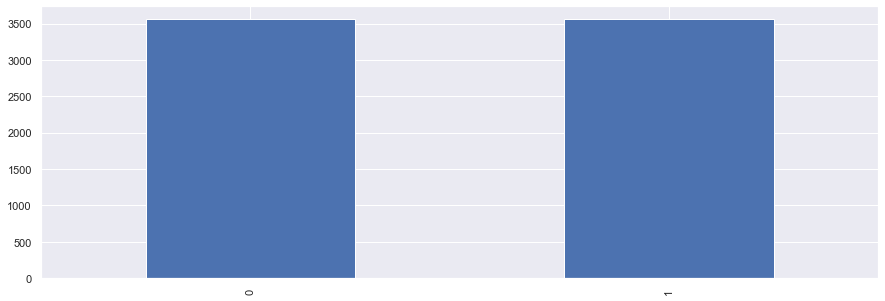

In [37]:
#Balance Data Using SMOTE
s = SMOTE()
X, y = s.fit_resample(X, y)
ros_chd_plot= y.value_counts().plot(kind='bar')
plt.show()

Accuracy with Logistic Regression before removing insignificant columns:  0.66
AUC score for model is 0.73
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       709
           1       0.66      0.66      0.66       715

    accuracy                           0.66      1424
   macro avg       0.66      0.66      0.66      1424
weighted avg       0.66      0.66      0.66      1424



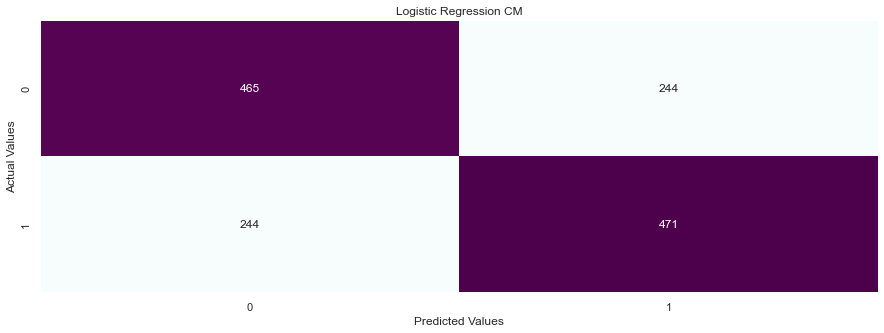

array([[465, 244],
       [244, 471]], dtype=int64)

In [38]:
##Plot function for confusion matrix and Log Regression Modeling
def plot_confusion_matrix(y_test, y_pred, plt_title):
    cm=confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap='BuPu')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(plt_title)
    plt.show()
    return cm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

lr = LogisticRegression(random_state = 0)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
train_pred = lr.predict(X_train)

print('Accuracy with Logistic Regression before removing insignificant columns: ',round(accuracy_score(y_test,y_pred),2))
print(f'AUC score for model is {np.round(roc_auc_score(y, lr.predict_proba(X)[:, 1]),2)}')
plot_confusion_matrix(y_test, y_pred, 'Logistic Regression CM')


XGBoost Accuracy Score:  0.875
AUC score for model is 0.96
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       709
           1       0.90      0.84      0.87       715

    accuracy                           0.88      1424
   macro avg       0.88      0.88      0.87      1424
weighted avg       0.88      0.88      0.87      1424



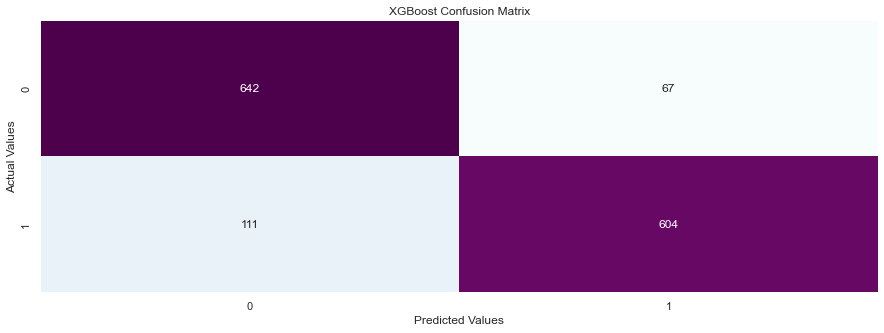

array([[642,  67],
       [111, 604]], dtype=int64)

In [39]:
#XGBoost Modeling
xgb_classifier=xgb.XGBClassifier(colsample_bytree= 0.6,
                                 eval_metric= 'logloss',
                                 gamma= 2,
                                 learning_rate= 0.1,
                                 max_depth= 5,
                                 min_child_weight= 1,
                                 subsample= 0.8,
                                 use_label_encoder=False,
                                 verbosity = 0)
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)
accuracy_score(y_test,y_pred_xgb)
print('XGBoost Accuracy Score: ',accuracy_score(y_test, y_pred_xgb))
print(f'AUC score for model is {np.round(roc_auc_score(y, xgb_classifier.predict_proba(X)[:, 1]),2)}')
plot_confusion_matrix(y_test, y_pred_xgb, 'XGBoost Confusion Matrix')

KNN Accuracy Score:  0.88
AUC score for model is 0.98
              precision    recall  f1-score   support

           0       0.97      0.77      0.86       709
           1       0.81      0.98      0.89       715

    accuracy                           0.88      1424
   macro avg       0.89      0.88      0.87      1424
weighted avg       0.89      0.88      0.87      1424



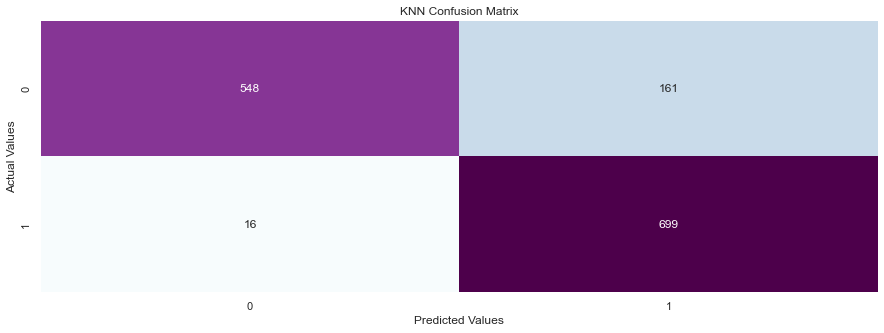

In [40]:
#KNN Modeling
knn_classifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p=2)
knn_classifier.fit(X_train, y_train)
y_pred_knn=knn_classifier.predict(X_test)
print('KNN Accuracy Score: ',round(accuracy_score(y_test,y_pred_knn),2))
print(f'AUC score for model is {np.round(roc_auc_score(y, knn_classifier.predict_proba(X)[:, 1]),2)}')
cm_knn=plot_confusion_matrix(y_test, y_pred_knn, 'KNN Confusion Matrix')

Random Forest Classifier Accuracy Score:  0.9
AUC score for model is 0.73
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       709
           1       0.90      0.91      0.90       715

    accuracy                           0.90      1424
   macro avg       0.90      0.90      0.90      1424
weighted avg       0.90      0.90      0.90      1424



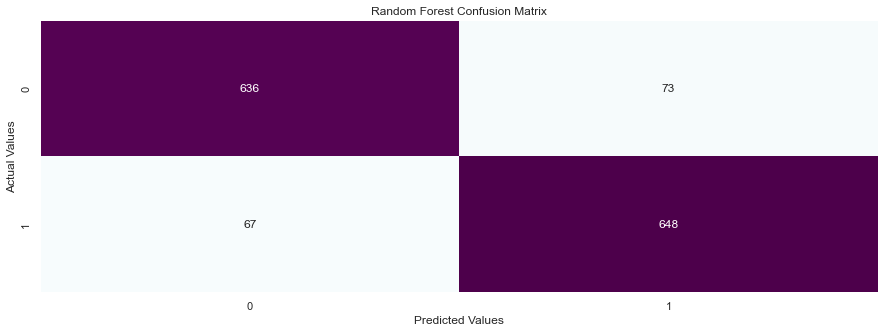

In [41]:
#Random Forest Classifier Modeling
rfc=RandomForestClassifier(bootstrap= True,
                           n_estimators= 600,
                           random_state=0)
rfc.fit(X_train, y_train)
y_pred_rfc=rfc.predict(X_test)
print('Random Forest Classifier Accuracy Score: ',round(accuracy_score(y_test,y_pred_rfc),2))
print(f'AUC score for model is {np.round(roc_auc_score(y, lr.predict_proba(X)[:, 1]),2)}')
cm_rfc=plot_confusion_matrix(y_test, y_pred_rfc, 'Random Forest Confusion Matrix')

Random Forest Classifier Accuracy Score:  0.61
AUC score for model is 0.69
              precision    recall  f1-score   support

           0       0.58      0.80      0.67       709
           1       0.68      0.42      0.52       715

    accuracy                           0.61      1424
   macro avg       0.63      0.61      0.59      1424
weighted avg       0.63      0.61      0.59      1424



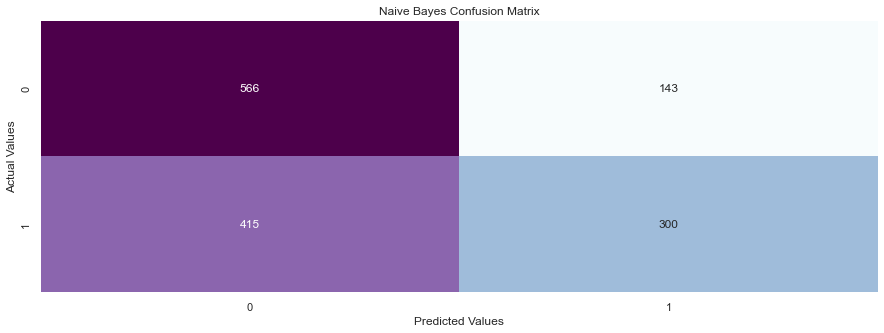

In [42]:
#Naive Bayes Modeling
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb=nb.predict(X_test)
print('Random Forest Classifier Accuracy Score: ',round(accuracy_score(y_test,y_pred_nb),2))
print(f'AUC score for model is {np.round(roc_auc_score(y, nb.predict_proba(X)[:, 1]),2)}')
cm_rfc=plot_confusion_matrix(y_test, y_pred_nb, 'Naive Bayes Confusion Matrix')